Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
df=pd.read_csv('Ad_Click_prediciton_Uncleaned.csv')

# Check for missing values and count them in each column
print("\nMissing values (absolute):\n", df.isnull().sum())


Missing values (absolute):
 session_id                    0
DateTime                      0
user_id                       0
product                       0
campaign_id                   0
webpage_id                    0
product_category_1            0
product_category_2        76171
user_group_id              5684
gender                     5684
age_level                  5684
user_depth                 5684
city_development_index    34609
var_1                         0
dtype: int64


DateTime parsing + feature extraction

In [3]:
# try parsing both ways, pick the one with fewer NaT
dt_try1 = pd.to_datetime(df['DateTime'], dayfirst=False, errors='coerce', infer_datetime_format=True)
dt_try2 = pd.to_datetime(df['DateTime'], dayfirst=True,  errors='coerce', infer_datetime_format=True)

df['DateTime'] = dt_try1.fillna(dt_try2)

# If parsing left NaT, investigate and handle (example: logging)
n_missing_dt = df['DateTime'].isna().sum()
print(f"Number of unparsed DateTime rows: {n_missing_dt}\n")

df['hour'] = df['DateTime'].dt.hour
df['day'] = df['DateTime'].dt.day
df['month'] = df['DateTime'].dt.month
df['weekday'] = df['DateTime'].dt.weekday  # Monday=0
df['is_weekend'] = df['weekday'].isin([5,6]).astype('int8')

# Quick check
print(df[['DateTime','hour','day','month','weekday','is_weekend']].head())

Number of unparsed DateTime rows: 0

    DateTime  hour  day  month  weekday  is_weekend
0 2017-07-08     0    8      7        5           1
1 2017-07-08     0    8      7        5           1
2 2017-07-08     0    8      7        5           1
3 2017-07-08     0    8      7        5           1
4 2017-07-08     0    8      7        5           1


C:\Users\karta\AppData\Local\Temp\ipykernel_32040\3547920696.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt_try1 = pd.to_datetime(df['DateTime'], dayfirst=False, errors='coerce', infer_datetime_format=True)
C:\Users\karta\AppData\Local\Temp\ipykernel_32040\3547920696.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt_try2 = pd.to_datetime(df['DateTime'], dayfirst=True,  errors='coerce', infer_datetime_format=True)


Handle High Missingness

In [4]:
# product_category_2: many NaNs (~59%). Use -1 as an explicit missing category.
df['product_category_2'] = df['product_category_2'].fillna(-1)

# create missing flag (1 if originally missing)
df['product_category_2_missing'] = (df['product_category_2'] == -1).astype('int8')

# Convert to category for memory and modeling
df['product_category_2'] = df['product_category_2'].astype('category')

# city_development_index: treat missing as -1 / Unknown
df['city_development_index'] = df['city_development_index'].fillna(-1)
df['city_development_index_missing'] = (df['city_development_index'] == -1).astype('int8')
df['city_development_index'] = df['city_development_index'].astype('category')

# Quick verification
print("product_category_2 missing flag counts:")
print(df['product_category_2_missing'].value_counts())
print("city_development_index missing flag counts:")
print(df['city_development_index_missing'].value_counts())

product_category_2 missing flag counts:
product_category_2_missing
1    76171
0    52687
Name: count, dtype: int64
city_development_index missing flag counts:
city_development_index_missing
0    94249
1    34609
Name: count, dtype: int64


Handle Moderate Missigness

In [5]:
# user_group_id: fillna(-1) and convert to category
df['user_group_id'] = df['user_group_id'].fillna(-1)
df['user_group_id_missing'] = (df['user_group_id'] == -1).astype('int8')
df['user_group_id'] = df['user_group_id'].astype('category')

# gender: standardize text, fill missing with 'Unknown'
df['gender'] = df['gender'].astype(str).str.strip()  # convert to str to avoid type errors
# Fix common shorthand/typos (if present), then fillna/Unknown
df['gender'] = df['gender'].replace({'nan': np.nan})  # revert literal 'nan' strings if any
df['gender'] = df['gender'].fillna('Unknown')
df['gender'] = df['gender'].str.title().replace({'M':'Male','F':'Female'})  # normalize common abbrev
df['gender_unknown'] = (df['gender'] == 'Unknown').astype('int8')

# age_level: treat 0 as unknown (replace 0 -> NaN first), then fill with -1
df['age_level'] = df['age_level'].replace(0, np.nan)
df['age_level'] = df['age_level'].fillna(-1)
df['age_level_missing'] = (df['age_level'] == -1).astype('int8')
df['age_level'] = df['age_level'].astype('category')

# user_depth: fillna with -1, convert to category
df['user_depth'] = df['user_depth'].fillna(-1)
df['user_depth_missing'] = (df['user_depth'] == -1).astype('int8')
df['user_depth'] = df['user_depth'].astype('category')

# verification
cols_to_check = ['user_group_id_missing','gender_unknown','age_level_missing','user_depth_missing']
print(df[cols_to_check].sum())

user_group_id_missing    5684
gender_unknown           5684
age_level_missing        5735
user_depth_missing       5684
dtype: int64


Convert Low-Cardinality Text Columns to 'category' dtype (Saves Memory + Helps Tree Models)

In [6]:
small_cat_cols = ['product', 'gender', 'product_category_1']
for col in small_cat_cols:
    df[col] = df[col].astype('category')

# Downcast integer columns where safe (reduces memory)
int_cols = [c for c in df.select_dtypes(include=['int64']).columns if c not in ['var_1']]
for col in int_cols:
    df[col] = pd.to_numeric(df[col], downcast='unsigned')

# quick dtype overview after changes
print(df.dtypes.loc[sorted(df.columns)])

DateTime                          datetime64[ns]
age_level                               category
age_level_missing                           int8
campaign_id                               uint32
city_development_index                  category
city_development_index_missing              int8
day                                        int32
gender                                  category
gender_unknown                              int8
hour                                       int32
is_weekend                                  int8
month                                      int32
product                                 category
product_category_1                      category
product_category_2                      category
product_category_2_missing                  int8
session_id                                uint32
user_depth                              category
user_depth_missing                          int8
user_group_id                           category
user_group_id_missin

Encoding Strategies for Modeling

In [7]:
# One-hot encoding for small-cardinality 'product' (A-J)
product_one = pd.get_dummies(df['product'], prefix='product', dummy_na=False)
df = pd.concat([df, product_one], axis=1)

# Label encoding for simple categorical columns (product, gender) - simple integer labels
le_prod = LabelEncoder()
df['product_label'] = le_prod.fit_transform(df['product'].astype(str))

le_gender = LabelEncoder()
df['gender_label'] = le_gender.fit_transform(df['gender'].astype(str))

# Frequency encoding for high-cardinality ID features (campaign_id, webpage_id)
# Frequency encoding converts a category to its frequency count in the dataset.
for col in ['campaign_id', 'webpage_id', 'user_id']:
    freq = df[col].value_counts()
    df[f'{col}_freq'] = df[col].map(freq).fillna(0).astype('int32')

# Convert categorical categories to numeric codes (fast)
# category codes map each category to integer IDs 0..N-1 (good for tree-based models)
for col in ['product_category_2', 'city_development_index', 'user_group_id', 'age_level', 'user_depth']:
    if str(df[col].dtype) == 'category':
        df[f'{col}_code'] = df[col].cat.codes  # -1 means NaN if there were NaNs; we've handled NaNs earlier

# Quick peek at new columns
print(df[['product_label','gender_label','campaign_id_freq','webpage_id_freq']].head())

   product_label  gender_label  campaign_id_freq  webpage_id_freq
0              9             1              6514             6514
1              8             2             36191            36191
2              8             2             36191            36191
3              6             1             36191            36191
4              7             0             36191            36191


Verify Changes and Save a Cleaned CSV Snapshot

In [8]:
# confirm no unexpected nulls remain in the key columns we intended to clean
cols_of_interest = [
    'product_category_2', 'product_category_2_missing',
    'city_development_index', 'city_development_index_missing',
    'gender', 'gender_unknown',
    'age_level', 'age_level_missing',
    'user_depth', 'user_depth_missing'
]
print(df[cols_of_interest].isna().sum())  # should be zero for the columns we've filled (except raw if kept)

# view overall missing summary
print("Overall missing counts after cleaning:")
print(df.isna().sum())

# Save cleaned copy (versioned)
df.to_csv("Ad_Click_prediciton_Cleaned.csv", index=False)

product_category_2                0
product_category_2_missing        0
city_development_index            0
city_development_index_missing    0
gender                            0
gender_unknown                    0
age_level                         0
age_level_missing                 0
user_depth                        0
user_depth_missing                0
dtype: int64
Overall missing counts after cleaning:
session_id                        0
DateTime                          0
user_id                           0
product                           0
campaign_id                       0
webpage_id                        0
product_category_1                0
product_category_2                0
user_group_id                     0
gender                            0
age_level                         0
user_depth                        0
city_development_index            0
var_1                             0
hour                              0
day                               0
month       

Using Matplotlib and Seaborn for Data Visualization

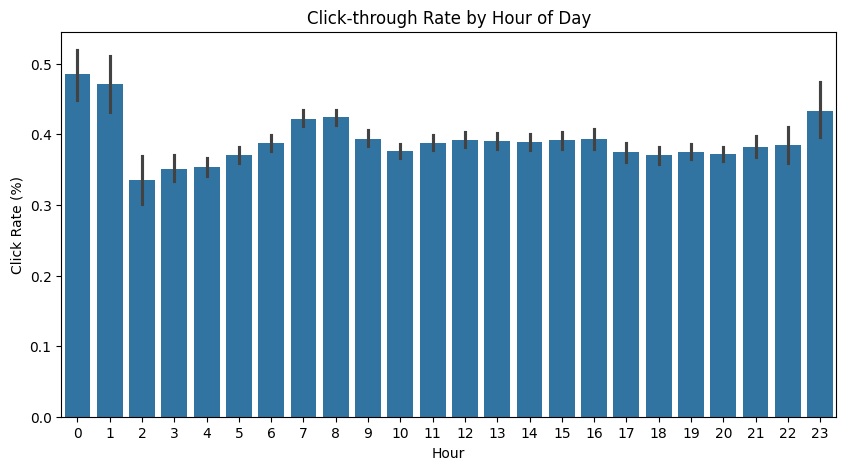

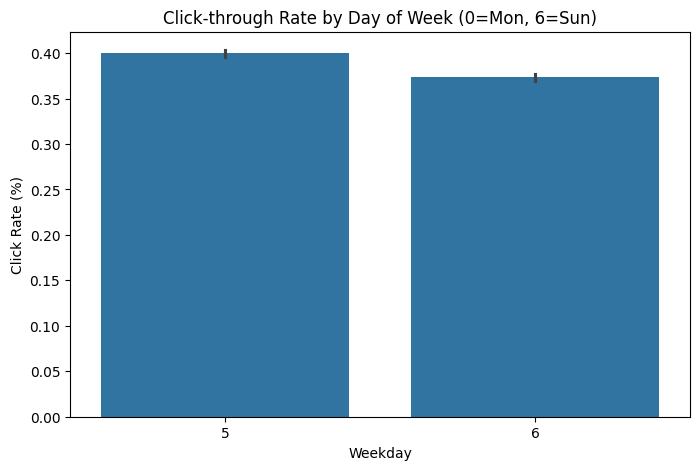

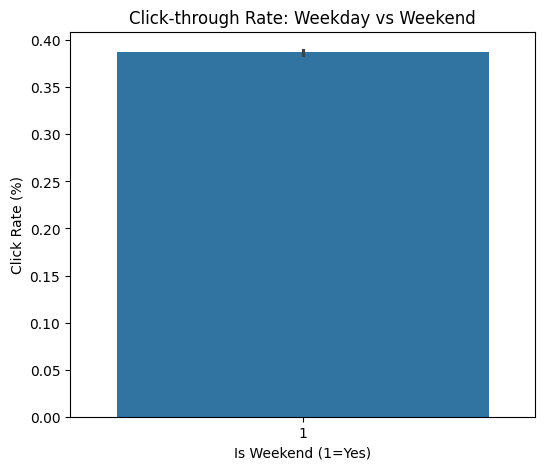

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# clicks by hour
plt.figure(figsize=(10,5))
sns.barplot(x="hour", y="var_1", data=df, estimator=lambda x: sum(x)/len(x))  
plt.title("Click-through Rate by Hour of Day")
plt.ylabel("Click Rate (%)")
plt.xlabel("Hour")
plt.show()

# clicks by weekday
plt.figure(figsize=(8,5))
sns.barplot(x="weekday", y="var_1", data=df, estimator=lambda x: sum(x)/len(x))
plt.title("Click-through Rate by Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Click Rate (%)")
plt.xlabel("Weekday")
plt.show()

# weekend vs weekday
plt.figure(figsize=(6,5))
sns.barplot(x="is_weekend", y="var_1", data=df, estimator=lambda x: sum(x)/len(x))
plt.title("Click-through Rate: Weekday vs Weekend")
plt.ylabel("Click Rate (%)")
plt.xlabel("Is Weekend (1=Yes)")
plt.show()


C:\Users\karta\AppData\Local\Temp\ipykernel_32040\4109703706.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_campaigns.index, y=top_campaigns.values, palette="viridis")


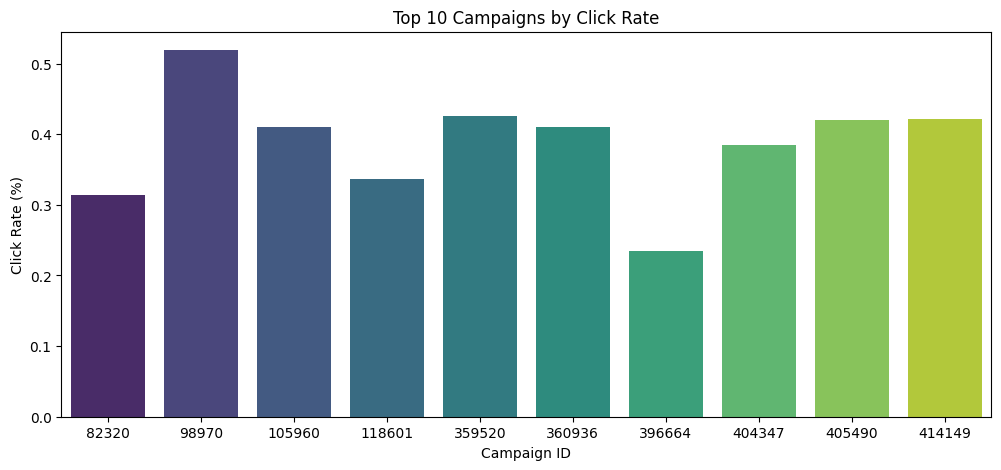

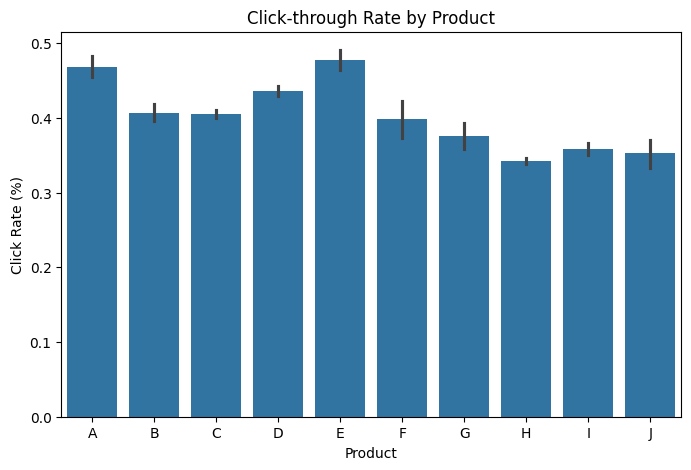

In [ ]:
# campaign performance
top_campaigns = (
    df.groupby("campaign_id")["var_1"].mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(12,5))
sns.barplot(x=top_campaigns.index, y=top_campaigns.values, palette="viridis")
plt.title("Top 10 Campaigns by Click Rate")
plt.ylabel("Click Rate (%)")
plt.xlabel("Campaign ID")
plt.show()

# product performance
plt.figure(figsize=(8,5))
sns.barplot(x="product", y="var_1", data=df, estimator=lambda x: sum(x)/len(x))
plt.title("Click-through Rate by Product")
plt.ylabel("Click Rate (%)")
plt.xlabel("Product")
plt.show()


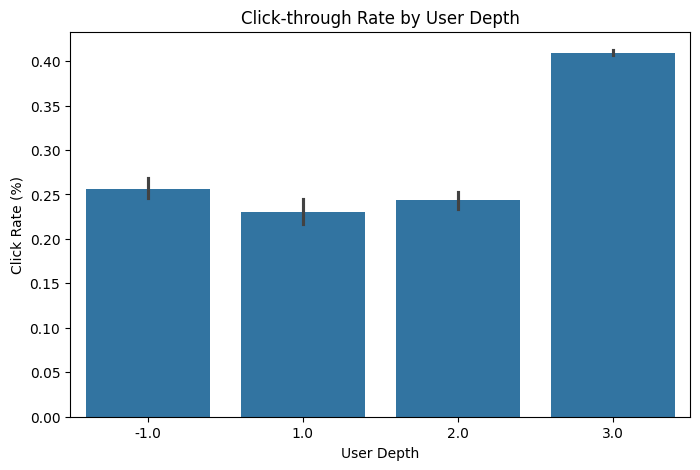

In [11]:
# User Depth vs Click Likelihood
plt.figure(figsize=(8,5))
sns.barplot(x="user_depth", y="var_1", data=df, estimator=lambda x: sum(x)/len(x))
plt.title("Click-through Rate by User Depth")
plt.ylabel("Click Rate (%)")
plt.xlabel("User Depth")
plt.show()

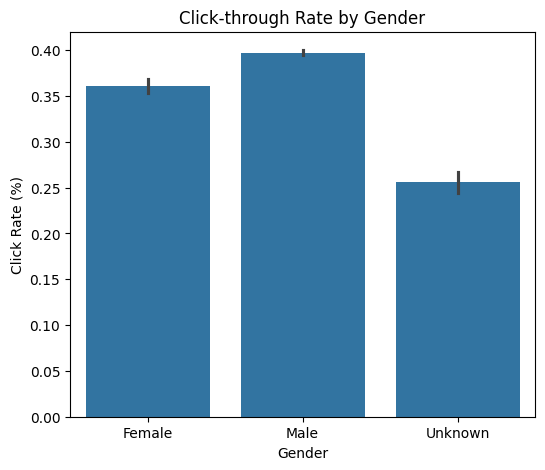

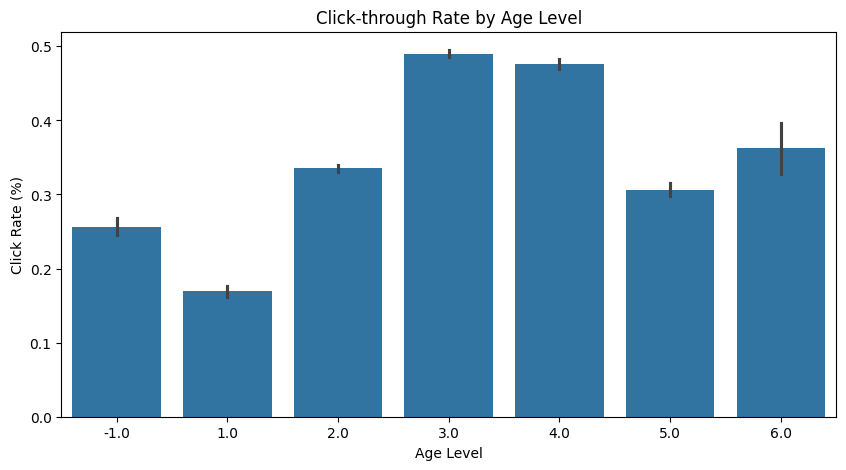

In [12]:
# gender
plt.figure(figsize=(6,5))
sns.barplot(x="gender", y="var_1", data=df, estimator=lambda x: sum(x)/len(x))
plt.title("Click-through Rate by Gender")
plt.ylabel("Click Rate (%)")
plt.xlabel("Gender")
plt.show()

# age level
plt.figure(figsize=(10,5))
sns.barplot(x="age_level", y="var_1", data=df, estimator=lambda x: sum(x)/len(x))
plt.title("Click-through Rate by Age Level")
plt.ylabel("Click Rate (%)")
plt.xlabel("Age Level")
plt.show()